# Assignment 4: Transformer, Pretrained Transformer, and LLM

With your environment activated int the terminal, run:
```
mamba env create -n cs5293-4 python=3.10
pip install -r requirements.txt
##Your VSCode may complain sometime you need to install ipykernel using the following commands. If not, then  just ignore this. 
#mamba install -n cs5293-4 ipykernel  --force-reinstall 
```

In this assignment, you have to submit two things:
* (1) The whole folder with your code (not with .cache or your model checkpoints)
* (2) A report to summarize your experiments
* (3) AI Usage Statement 

# Part 1: Machine Tranlation with Seq2Seq, Attention, Transformer (60')
In this part, you will train a machine translation model from French to English to explore the invention of Seq2Seq model and Attention Mechanism, and finally transformer.

## Section 1.1. Setup and Data Exploration (0', But run this tutorial)

In [1]:
# please fix byself to make the corresponding packages work properly.
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.nn import GRU, LSTM, TransformerEncoder, TransformerEncoderLayer, MultiheadAttention, TransformerDecoder, TransformerDecoderLayer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The English to French pairs in `data/eng-fra.txt` are seperated by a tab
separated list of translation pairs:

``` {.sh}
I am cold.    J'ai froid.
```

In [2]:
# Let us first explore the data with some shell commands we have learned in assignment 1.
# Explore the data simply with shell command (linux or macOS,windows users please use git bash or wsl)
# echo -e will enable interpretation of backslash escapes
# \e[1;34m will set the color to blue and bold for "English"
# \e[1;32m will set the color to green and bold for "French"
# \e[0m will reset the color to default
# head will show the first 10 lines of the data file
# cut will extract the first two columns (seperated by tab) from the data file
# column will format the output into a table with tab as the seperator
!(echo -e "\e[1;34mEnglish\t\e[1;32mFrench\e[0m"; head ../data/eng-fra.txt | cut -f1,2) | column -t -s $'\t'

English  French
Go.      Va !
Run!     Cours !
Run!     Courez !
Wow!     Ça alors !
Fire!    Au feu !
Help!    À l'aide !
Jump.    Saute.
Stop!    Ça suffit !
Stop!    Stop !
Stop!    Arrête-toi !


We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count which will be used to replace rare words later.

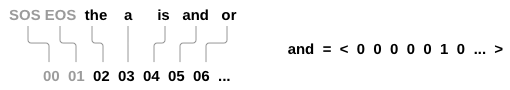

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the `reverse`
flag to reverse the pairs.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are too many example sentences and we want to train something quickly in this notebook, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes replaced earlier).

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-   Read text file and split into lines, split lines into pairs
-   Normalize text, filter by length and content
-   Make word lists from sentences in pairs

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['je pars en voyage', 'i m going on a trip']


## Section 1.2 Seq2Seq Model for Machine Translation (10')

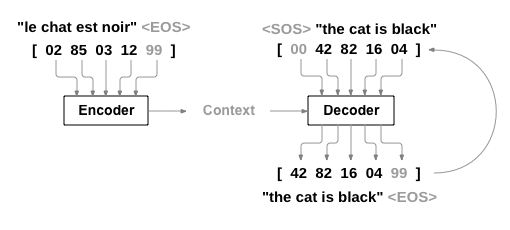

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215), or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting
of two RNNs called the encoder and decoder. The encoder reads an input
sequence and outputs a single vector, and the decoder reads that vector
to produce an output sequence. The RNN encoder and decoder could also be replaced with other architectures such as Transformer, CNN, or GNN depends on your inputs and outputs.


Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence `Je ne suis pas le chat noir` →
`I am not the black cat`. Most of the words in the input sentence have a
direct translation in the output sentence, but are in slightly different
orders, e.g. `chat noir` and `black cat`. Because of the `ne/pas`
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the \"meaning\" of the input sequence into a single
vector --- a single point in some N dimensional space of sentences.

#### Task 1.2.1 The Encoder (5')

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.
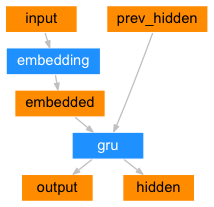


In [21]:
# Define the Encoder RNN with GRU(a verionsion of RNN with less parameters than LSTM)
class EncoderRNN(nn.Module):
    # Initialize the encoder
    # define embedding layer, GRU layer and dropout layer
    # input size: size of the input vocabulary
    # hidden size: size of the hidden state vector
    # dropout_p: dropout probability
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # Here we initialize a new embedding layer from scratch with input vocabulary size and hidden size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # We could use pretrained embedding such as GloVe or Word2Vec by loading the weights into the embedding layer
        # Please try this in self-exploration!!!
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        # here we simply use GRU to process the embedded input
        # Please return the whole output and the last hidden state.
        # What is their shapes? Are the different when batch_first=True or False?
        # Print the shapes for better understanding
        # Add your code here!!!
        output, hidden = self.gru(embedded)
        return output, hidden

#### Task 1.2.2 The Decoder (5')

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string `<SOS>`
token, and the first hidden state is the context vector (the encoder\'s
last hidden state).

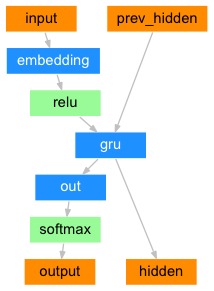

In [22]:
### Your implementation of DecoderRNN forward function with teacher forcing ###
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        # Run the decoder for MAX_LENGTH time steps
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                # add your code here!!! Particularly, set decoder_input to the i-th token of target_tensor
                # Pay attention to the shape of decoder_input
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop for future attention

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Task 1.2.3 Define the Seq2Seq and Training Setup (0')

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

\"Teacher forcing\" is the concept of using the real target outputs as
each next input, instead of using the decoder\'s guess as the next
input. Using teacher forcing causes it to converge faster but [when the
trained network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation
-intuitively it has learned to represent the output grammar and can
\"pick up\" the meaning once the teacher tells it the first few words,
but it has not properly learned how to create the sentence from the
translation in the first place.

Because of the freedom PyTorch\'s autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
`teacher_forcing_ratio` up to use more of it.

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.

In [9]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [10]:
# Train for one epoch
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    # Iterate through the dataloader
    for data in dataloader:
        input_tensor, target_tensor = data
        # Zero gradients for two optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        # Forward pass through encoder and decoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        # Compute loss and backpropagate
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

The whole training process looks like this:

-   Start a timer
-   Initialize optimizers and criterion
-   Create set of training pairs
-   Start empty losses array for plotting

Then we call `train` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.

Plotting is done with matplotlib, using the array of loss values
`plot_losses` saved while training.

In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    # finally show the plot
    plt.show()

In [12]:
# The whole training process
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Initialize optimizers and criterion
    # Why we need two optimizers here?
    # Because we have two different networks to optimize: encoder and decoder
    # Each network has its own parameters
    # In this way, we can optimize them separately
    # However, we can also use a single optimizer to optimize both networks
    # by passing the parameters of both networks to the optimizer
    # Please try this in self-exploration with parameter grouping!!!
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder\'s predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder\'s
attention outputs for display later.

In [13]:
# Evaluate the model on a given sentence
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # decoder_attention is None for now when using basic decoder without attention
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:

In [14]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        # input french sentence
        print('>', pair[0])
        # target english sentence
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        # generated english sentence
        print('<', output_sentence)
        print('')

In [15]:
# Use the above evaluate to evaluate the whole dataset and compute the BLEU score
def evaluateDataset(encoder, decoder, input_lang, output_lang, pairs):
    from nltk.translate.bleu_score import sentence_bleu
    total_bleu_score = 0
    for pair in pairs:
        reference = [pair[1].split(' ')]
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        # remove <EOS>
        if output_words[-1] == '<EOS>':
            output_words = output_words[:-1]
        candidate = output_words
        bleu_score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))
        total_bleu_score += bleu_score
    average_bleu_score = total_bleu_score / len(pairs)
    return average_bleu_score

### Task 1.2.4 Training the Machine Translation Model(0')

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 10-20 minutes on CPU we\'ll get
some reasonable results.

!!! Important !!!
Please use the "interrupt"(not "restart") in jupernotebook to help your debug.
During the training, the weight will be updated, "interrupt" will stop the training but the weights has been updated. So you could evaluate the "already updated" model weight to debug. In this case, you don't need to wait until finishing.

In [18]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 56s (- 14m 14s) (5 6%) 1.6902
1m 50s (- 12m 52s) (10 12%) 0.9275
2m 43s (- 11m 48s) (15 18%) 0.6130
3m 34s (- 10m 42s) (20 25%) 0.4246
4m 25s (- 9m 44s) (25 31%) 0.3050
5m 19s (- 8m 52s) (30 37%) 0.2243
6m 16s (- 8m 3s) (35 43%) 0.1695
7m 8s (- 7m 8s) (40 50%) 0.1314
7m 59s (- 6m 12s) (45 56%) 0.1037
8m 46s (- 5m 15s) (50 62%) 0.0854
9m 36s (- 4m 21s) (55 68%) 0.0713
10m 27s (- 3m 29s) (60 75%) 0.0614
11m 14s (- 2m 35s) (65 81%) 0.0541
259m 26s (- 37m 3s) (70 87%) 0.0485
260m 13s (- 17m 20s) (75 93%) 0.0446
260m 59s (- 0m 0s) (80 100%) 0.0423


/tmp/ipykernel_11750/750344496.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Set dropout layers to `eval` mode

In [19]:
# why we need to set eval mode here?
# Because some layers like dropout and batchnorm behave differently during training and evaluation.
# In evaluation mode, dropout is disabled and batchnorm uses running statistics instead of batch statistics.
# Be sure to call model.eval() before running inference and model.train() before training.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> t es libre d y aller
= you re free to go
< you re free to go <EOS>

> je ne dors pas bien
= i m not sleeping well
< i m not sleeping well <EOS>

> tu es allemand n est ce pas ?
= you re german right ?
< you re german aren t you ? <EOS>

> je suis mecontente
= i m unhappy
< i m not busy <EOS>

> vous etes tous contre moi
= you re all against me
< you re all against me <EOS>

> il se trouve a son cote
= he s at her side
< he s at her side <EOS>

> il est tellement mignon !
= he s so cute
< he s not a very meticulous guy <EOS>

> vous etes plus grands que moi
= you re taller than i am
< you re taller than me <EOS>

> je suis habitue a la situation
= i m familiar with the situation
< i m used to the noise <EOS>

> elle est inquiete pour sa securite
= she is anxious about her safety
< she is anxious about her safety <EOS>



In [20]:
# get the bleu score on the whole dataset
bleu_score = evaluateDataset(encoder, decoder, input_lang, output_lang, pairs)
print("BLEU score on the whole dataset: %.4f" % bleu_score)

/home/tommaso/miniforge3/envs/cs5293-4/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score on the whole dataset: 0.7563


## Section 1.3 Seq2Seq with Context Vector At Every Decoding (10')

#### Problem 1: Faded Context Vector
The decoder only knows the source text via the single context. 
* The context vector will get faded after decoding for a few steps. 
* It hopes to use this single context vector to summarize all previous inputs (bottleneck)

Please fix this by providing the context vector to every step of decoding instead of just to the first step of decoding.  There are different ways to implement this, please simply inject the context vector into the GRU input before feeding into GRU.
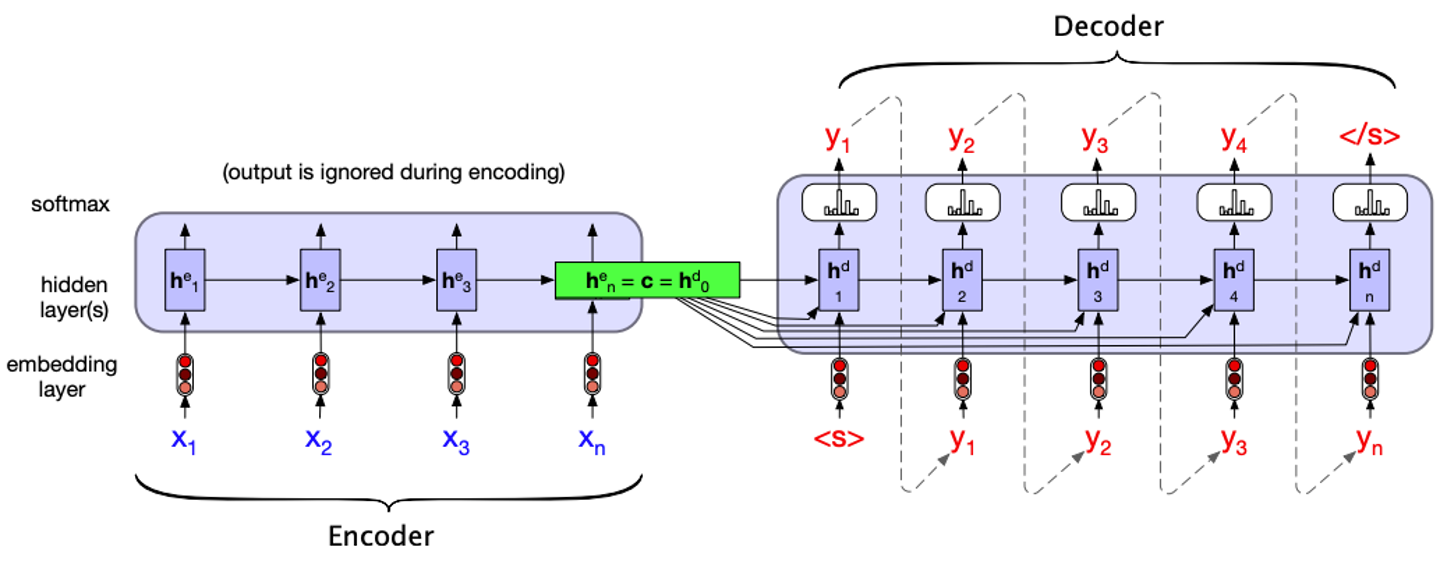

#### Task 1.3.1 ContextalDecoderRNN (10')

In [16]:
##### Problem 1: Faded Context Vector
# Please fix this by providing the context vector to every step of decoding instead of just to the first step of decoding.
class ContextualDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # Your code here!!! Please modify the decoder to take the context vector (encoder_outputs) at every step of decoding
        # Hint: 
        # 1. You need to concatenate the context vector with the embedded input at every step
        # 2. Pay attention to the shapes of the tensors when concatenating, You need to use torch.cat() function to concatenate tensors
        # 3. Learn from the previous DecoderRNN implementation with teacher forcing and without teacher forcing
        # Particularly, pay attention to the shape of decoder_input at every step
        # Add your code here!!!
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.full((batch_size, 1), SOS_token, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden  
        decoder_outputs = []

        context = encoder_hidden.transpose(0, 1)

        # to solve dimension issues
        project = nn.Linear(hidden_size * 2, hidden_size).to(device)

        for i in range(MAX_LENGTH):
            embedded = self.embedding(decoder_input)  
            rnn_input = torch.cat((embedded, context), dim=2)  #(batch, 1, 256)
            rnn_input = project(rnn_input)                     #(batch, 1, 128)
            output, decoder_hidden = self.gru(rnn_input, decoder_hidden)
            output = self.out(output)  
            decoder_outputs.append(output)
            
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

In [29]:
# train a new model with ContextualDecoderRNN
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# let redefine a new encoder and contextual decoder
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
contextual_decoder = ContextualDecoderRNN(hidden_size, output_lang.n_words).to(device)
train(train_dataloader, encoder, contextual_decoder, 80, print_every=5, plot_every=5)


Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 39s (- 9m 56s) (5 6%) 2.1879
1m 24s (- 9m 53s) (10 12%) 1.4586
2m 8s (- 9m 18s) (15 18%) 1.1168
2m 52s (- 8m 38s) (20 25%) 0.8839
3m 37s (- 7m 58s) (25 31%) 0.7130
4m 22s (- 7m 17s) (30 37%) 0.5900
5m 9s (- 6m 37s) (35 43%) 0.4968
5m 55s (- 5m 55s) (40 50%) 0.4242


KeyboardInterrupt: 

In [30]:
# why we need to set eval mode here?
# Because some layers like dropout and batchnorm behave differently during training and evaluation.
# In evaluation mode, dropout is disabled and batchnorm uses running statistics instead of batch statistics.
# Be sure to call model.eval() before running inference and model.train() before training.
encoder.eval()
contextual_decoder.eval()
evaluateRandomly(encoder, contextual_decoder)

> il cherche un emploi
= he is seeking employment
< he is seeking a a a <EOS>

> je suis marie maintenant
= i m married now
< i m married of left a now <EOS>

> je n ecoute pas
= i m not listening
< i m not not from yet <EOS>

> je vais aller dans ma chambre
= i m going to go to my room
< i m going to have somewhere in this situation <EOS>

> je suis ici en tant que touriste
= i m here as a tourist
< i m as old as tourist <EOS>

> vous etes seules n est ce pas ?
= you re alone aren t you ?
< you re depressed aren t you ? <EOS>

> je suis coince dans mon boulot
= i m stuck in my job
< i m halfway in my my jam <EOS>

> nous sommes en ville
= we re in town
< we re sitting of town town <EOS>

> nous sommes tout a fait seuls
= we re quite alone
< we re quite ready ready <EOS>

> je peux nager tres vite
= i am a fast swimmer
< i m dying a to swim to <EOS>



In [31]:
# get the bleu score on the whole dataset
bleu_score = evaluateDataset(encoder, contextual_decoder, input_lang, output_lang, pairs)
print("BLEU score on the whole dataset: %.4f" % bleu_score)

/home/tommaso/miniforge3/envs/cs5293-4/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score on the whole dataset: 0.4556


## Section 1.4 Seq2Seq with Attention-based Context Vector (15')

#### Task 1.4.1 Attention Decoder (15')


If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to \"focus\" on a different part of
the encoder\'s outputs for every step of the decoder\'s own outputs.
First we calculate a set of *attention weights*. These will be
multiplied by the encoder output vectors to create a weighted
combination. The result (called `attn_applied` in the code) should
contain information about that specific part of the input sequence, and
thus help the decoder choose the right output words.
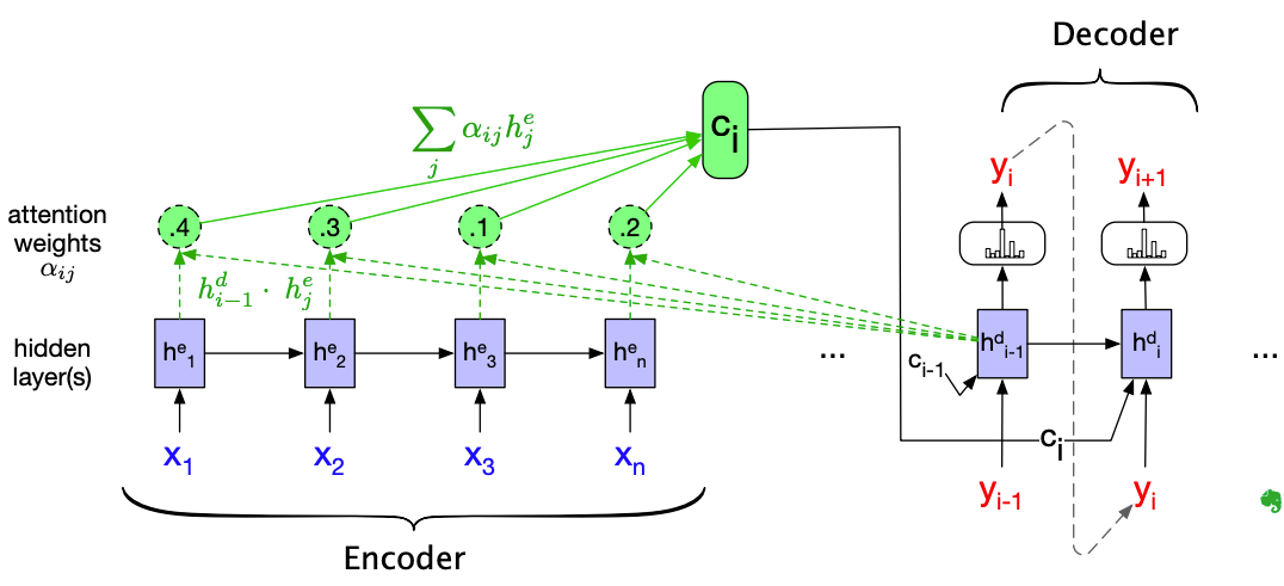

Calculating the attention weights is done with another feed-forward
layer `attn`, using the decoder\'s input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

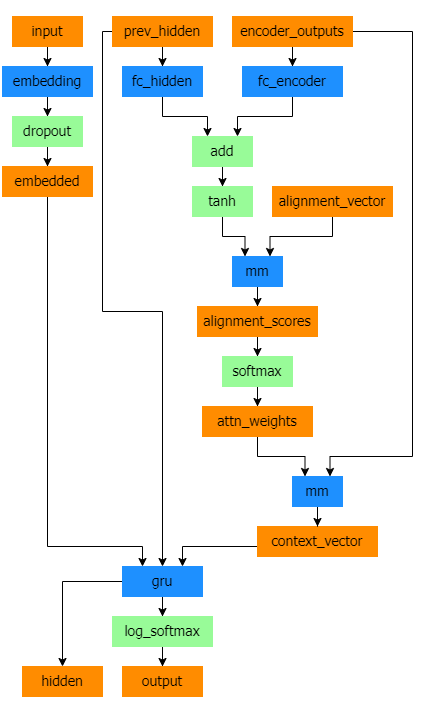

Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in
neural machine translation tasks. It was introduced by Bahdanau et al.
in their paper titled [Neural Machine Translation by Jointly Learning to
Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
attention mechanism employs a learned alignment model to compute
attention scores between the encoder and decoder hidden states. It
utilizes a feed-forward neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as
Luong attention, which computes attention scores by taking the dot
product between the decoder hidden state and the encoder hidden states.
It does not involve the non-linear transformation used in Bahdanau
attention.

In this tutorial, we will be using Bahdanau attention. However, it would
be a valuable exercise to explore modifying the attention mechanism to
use Luong attention.

In [17]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        # Your code here!!! Please implement the attention-based decoder
        # Hint: At every step of decoding, compute the attention weights and context vector using the BahdanauAttention module
        # Then concatenate the context vector with the embedded input before feeding into the GRU
        # Learn from the previous DecoderRNN implementation with teacher forcing and without teacher forcing
        # Particularly, pay attention to the shape of decoder_input at every step
        # Add your code here!!!
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.full((batch_size, 1), SOS_token, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        all_attn_weights = []
        for i in range(MAX_LENGTH):
            embedded = self.dropout(self.embedding(decoder_input)) 
            query = decoder_hidden.transpose(0, 1)                  
            context, attn_weights = self.attention(query, encoder_outputs)
            rnn_input = torch.cat((embedded, context), dim=2)      
            output, decoder_hidden = self.gru(rnn_input, decoder_hidden)
            output = self.out(output)                               
            decoder_outputs.append(output)
            all_attn_weights.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, all_attn_weights

In [23]:
# train a new model with AttnDecoderRNN
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# let redefine a new encoder and attention decoder
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
train(train_dataloader, encoder, attn_decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
1m 13s (- 18m 29s) (5 6%) 1.5451
2m 24s (- 16m 51s) (10 12%) 0.6918
3m 35s (- 15m 35s) (15 18%) 0.3643
4m 46s (- 14m 19s) (20 25%) 0.2038
5m 57s (- 13m 5s) (25 31%) 0.1256
7m 6s (- 11m 51s) (30 37%) 0.0858
8m 16s (- 10m 38s) (35 43%) 0.0652
9m 26s (- 9m 26s) (40 50%) 0.0532
10m 36s (- 8m 15s) (45 56%) 0.0461
11m 49s (- 7m 5s) (50 62%) 0.0409
13m 6s (- 5m 57s) (55 68%) 0.0381
14m 20s (- 4m 46s) (60 75%) 0.0351
15m 30s (- 3m 34s) (65 81%) 0.0330
16m 42s (- 2m 23s) (70 87%) 0.0317
17m 54s (- 1m 11s) (75 93%) 0.0302
19m 8s (- 0m 0s) (80 100%) 0.0295


/tmp/ipykernel_10278/750344496.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [24]:
# why we need to set eval mode here?
# Because some layers like dropout and batchnorm behave differently during training and evaluation.
# In evaluation mode, dropout is disabled and batchnorm uses running statistics instead of batch statistics.
# Be sure to call model.eval() before running inference and model.train() before training.
encoder.eval()
attn_decoder.eval()
evaluateRandomly(encoder, attn_decoder)

> tu es vieille
= you re old
< you re old enough <EOS>

> je fais le bon choix
= i m doing the right thing
< i m doing the right thing <EOS>

> il aime beaucoup la musique
= he is very fond of music
< he is very fond of music <EOS>

> je ne suis certainement pas ton amie
= i m certainly not your friend
< i m certainly not your friend <EOS>

> je suis affole
= i m frantic
< i m frantic <EOS>

> je suis curieux
= i m curious
< i am curious <EOS>

> vous etes chanceuse
= you re fortunate
< you re fortunate <EOS>

> vous etes en train de mentir
= you are lying
< you are lying <EOS>

> je ne suis pas tres occupe
= i m not very busy
< i m not very busy <EOS>

> j attends de toi un travail serieux
= i am expecting some serious work from you
< i am expecting some serious work from you <EOS>



In [25]:
# get the bleu score on the whole dataset
bleu_score = evaluateDataset(encoder, attn_decoder , input_lang, output_lang, pairs)
print("BLEU score on the whole dataset: %.4f" % bleu_score)

/home/tommaso/miniforge3/envs/cs5293-4/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score on the whole dataset: 0.8951


A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run `plt.matshow(attentions)` to see attention output
displayed as a matrix. For a better viewing experience we will do the
extra work of adding axes and labels:

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipykernel_10278/164402544.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_10278/164402544.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

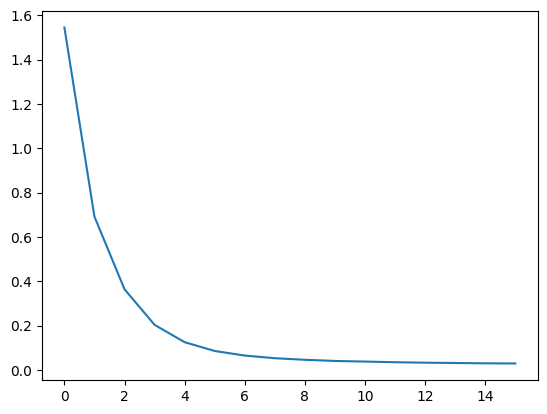

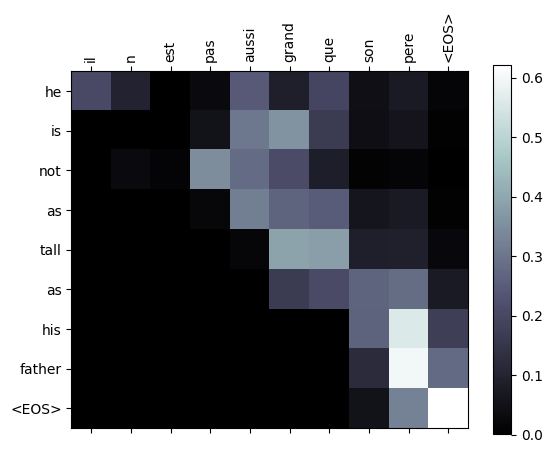

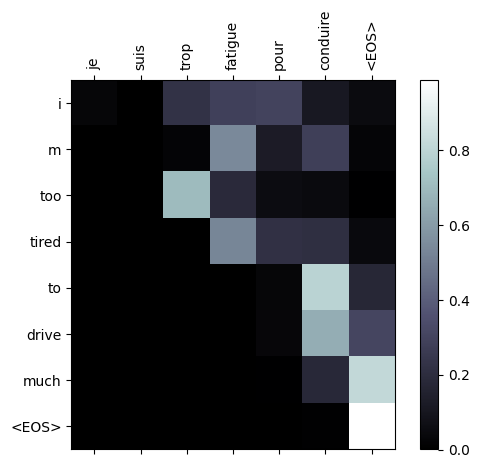

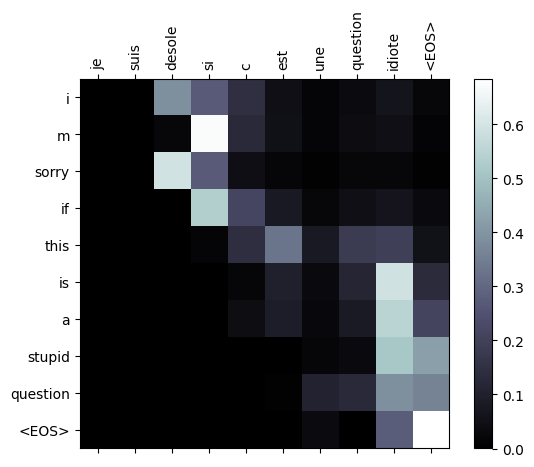

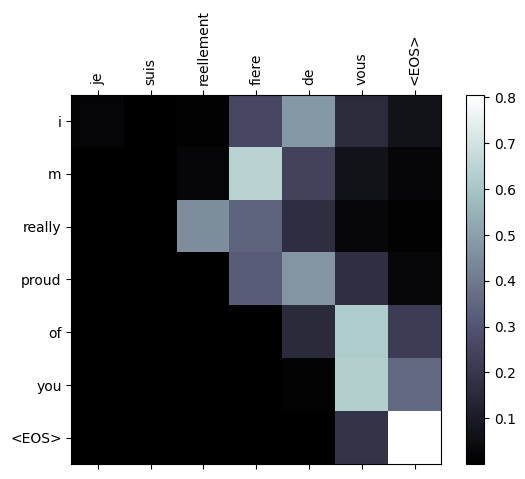

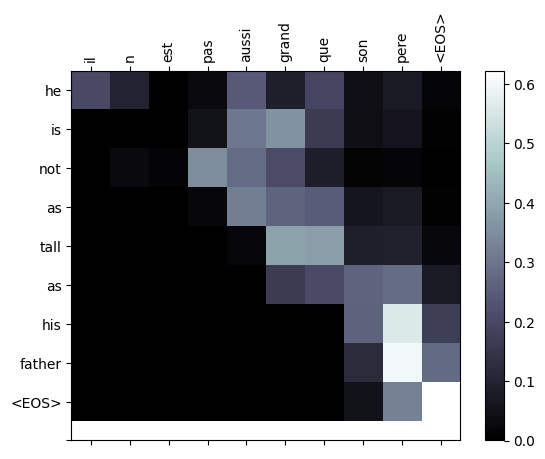

input = je suis trop fatigue pour conduire
output = i m too tired to drive much <EOS>


/tmp/ipykernel_10278/164402544.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_10278/164402544.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


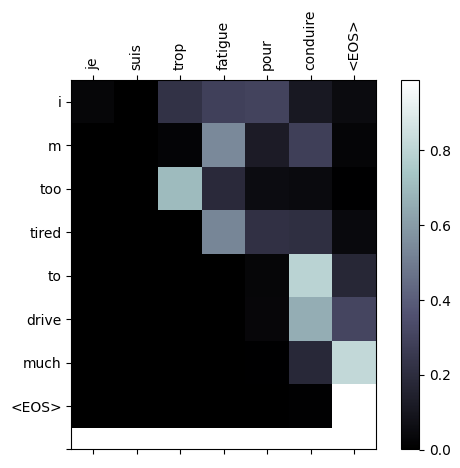

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


/tmp/ipykernel_10278/164402544.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_10278/164402544.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


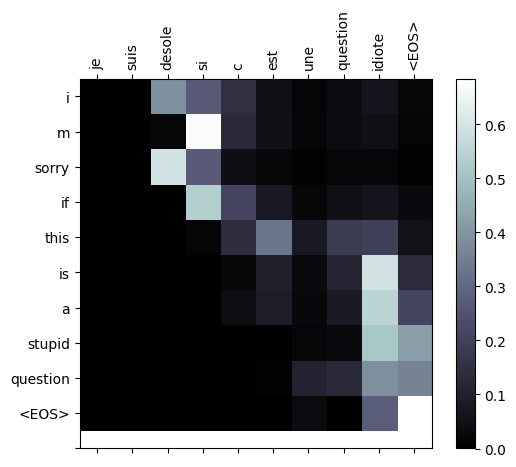

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


/tmp/ipykernel_10278/164402544.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_10278/164402544.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


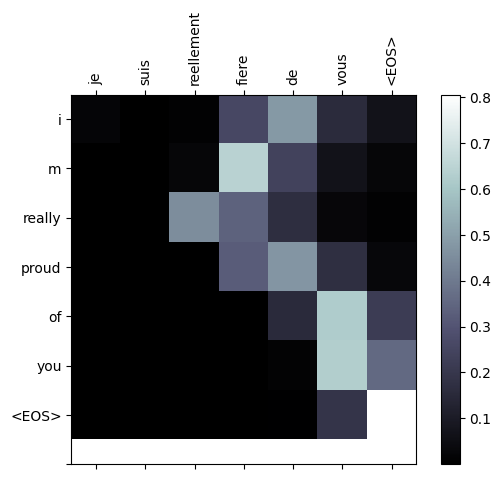

In [27]:
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.set_xticks(range(len(input_sentence.split(' ')) + 1))
    ax.set_yticks(range(len(output_words) + 1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, attn_decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    attn_matrix = torch.cat(attentions, dim=1) 
    attn_matrix = attn_matrix.squeeze(0)
    attn_matrix = attn_matrix[:len(output_words), :]
    showAttention(input_sentence, output_words, attn_matrix)

evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

## Section 1.5 Transformer-based Machine Translation (25')
There two excellent transformer jupyternote books at large, which covers a great amount details of transformer that we could cannot cover more in the class: ["The Illustrated Transfomer"](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar and ["The Annotated Transformer"](https://github.com/harvardnlp/annotated-transformer/) by harvardnlp lab.

Some one combined this two and create a single jupternotebook [here](https://github.com/vinsis/math-and-ml-notes/blob/master/notebooks/Transformer%20-%20Illustration%20and%20code.ipynb). Please read through them to understand the details of transformer. Train a tranfromer-based model on the above machine translation dataset from scratch. 

Positional Encoding (copied from the provided notebook, no changes)

In [27]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Model

In [28]:
# please implement a transformer-based model for the above translation task
# define a seq2seq transformer model for machine translation
class Seq2SeqTransformer(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, hidden_size, 
                 nhead, num_encoder_layers, num_decoder_layers, dim_feedforward=256, dropout=0.1):
        # dim_feedforward: the dimension of the feedforward network model in nn.TransformerEncoder and nn.TransformerDecoder
        # in this turorial, given the small size of the dataset, we use a small dim_feedforward
        # You may try a larger dim_feedforward in self-exploration!!!
        super(Seq2SeqTransformer, self).__init__()
        # besides the embedding layers, we also add a positional encoding layer to identify the position of each token in the sequence
        # it is shared between source and target
        self.src_emb = nn.Embedding(input_vocab_size, hidden_size)
        self.tgt_emb = nn.Embedding(output_vocab_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        self.pos_decoder = PositionalEncoding(hidden_size, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.fc_out = nn.Linear(hidden_size, output_vocab_size)
        self.hidden_size = hidden_size


    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        # besides the embedding layers, we also need to add the positional encoding to the embedded input
        # assume source and target are already on the same device as the model.
        src_emb = self.pos_encoder(self.src_emb(src) * math.sqrt(self.hidden_size))
        tgt_emb = self.pos_decoder(self.tgt_emb(tgt) * math.sqrt(self.hidden_size))

        memory = self.encoder(src_emb, mask=src_mask, src_key_padding_mask=src_padding_mask)
        output = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask,
                              tgt_key_padding_mask=tgt_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        output = self.fc_out(output)
        return F.log_softmax(output, dim=-1)            

Preprocessing adapted to transformers

In [29]:
# Special tokens adapted for trasnfoermers, i can't use SOS token as PAD token as done in the previouse code. 
PAD_token = 0
SOS_token = 1
EOS_token = 2

# class LANG modified with the new token 
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            PAD_token: "PAD",
            SOS_token: "SOS",
            EOS_token: "EOS"
        }
        self.n_words = 3  # Count PAD, SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1




Functions for Training and Evaluation

In [30]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def train_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()
    total_loss = 0

    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask = None
        tgt_seq_len = tgt_input.size(1)
        tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)

        src_padding_mask = (src == PAD_token)
        tgt_padding_mask = (tgt_input == PAD_token)

        optimizer.zero_grad()

        output = model(
            src=src,
            tgt=tgt_input,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask
        )

        loss = criterion(output.view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_dataloader)



def evaluate(model, src, max_len=MAX_LENGTH):
    model.eval()
    src = src.to(device)
    src_mask = None
    src_padding_mask = (src == PAD_token)

    with torch.no_grad():
        memory = model.encoder(
            model.pos_encoder(model.src_emb(src) * math.sqrt(model.hidden_size)),
            src_key_padding_mask=src_padding_mask
        )

        ys = torch.ones(1, 1).fill_(SOS_token).type_as(src).to(device)

        for i in range(max_len - 1):
            tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
            out = model.decoder(
                model.pos_decoder(model.tgt_emb(ys) * math.sqrt(model.hidden_size)),
                memory,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=src_padding_mask
            )
            out = model.fc_out(out[:, -1])
            prob = out.softmax(dim=-1)
            next_word = torch.argmax(prob, dim=-1).unsqueeze(0)
            ys = torch.cat([ys, next_word], dim=1)
            if next_word.item() == EOS_token:
                break
    return ys



def evaluate_dataset_bleu(model, dataloader, input_lang, output_lang, max_len=MAX_LENGTH):
    """
    Evaluate the Transformer on the whole dataset and compute BLEU score.
    """
    model.eval()
    smoothie = SmoothingFunction().method4

    references = []
    hypotheses = []

    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(device)
            tgt = tgt.to(device)

            for b in range(src.size(0)):
                
                input_seq = src[b].unsqueeze(0)
                target_seq = tgt[b].unsqueeze(0)

                pred_seq = evaluate(model, input_seq, max_len=max_len)[0]

                pred_tokens = [output_lang.index2word[idx.item()] for idx in pred_seq if idx.item() not in [PAD_token, EOS_token, SOS_token]]
                target_tokens = [output_lang.index2word[idx.item()] for idx in target_seq[0] if idx.item() not in [PAD_token, EOS_token, SOS_token]]

                if len(pred_tokens) == 0 or len(target_tokens) == 0:
                    continue

                references.append([target_tokens])
                hypotheses.append(pred_tokens)

    corpus_bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    print(f"\n===== BLEU Evaluation =====")
    print(f"Evaluated {len(hypotheses)} sentences")
    print(f"Corpus BLEU score: {corpus_bleu_score*100:.2f}")

    # Show a few example translations
    print("\n=== Sample translations ===")
    for i in range(min(5, len(hypotheses))):
        print(f"Target:     {' '.join(references[i][0])}")
        print(f"Predicted:  {' '.join(hypotheses[i])}\n")

    return corpus_bleu_score






MAIN

In [31]:

#Hyperparameters
batch_size = 32
hidden_size = 256
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.1
learning_rate = 1e-4
num_epochs = 10

#Load data
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)
input_vocab_size = input_lang.n_words
output_vocab_size = output_lang.n_words

print(f"Input vocab size: {input_vocab_size}")
print(f"Output vocab size: {output_vocab_size}")

#Create model
model = Seq2SeqTransformer(
    input_vocab_size=input_vocab_size,
    output_vocab_size=output_vocab_size,
    hidden_size=hidden_size,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=512,
    dropout=dropout
).to(device)

#Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=PAD_token)

#Training loop
print("\nStarting training...\n")
for epoch in range(1, num_epochs + 1):
    loss = train_epoch(model, optimizer, criterion, train_dataloader, device)
    print(f"Epoch [{epoch}/{num_epochs}] - Training Loss: {loss:.4f}")

print("\nTraining complete")

#Evaluate the Transformer with BLEU
bleu = evaluate_dataset_bleu(model, train_dataloader, input_lang, output_lang)
print(f"\nFinal BLEU score: {bleu*100:.2f}\n")


Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4602
eng 2992
Input vocab size: 4602
Output vocab size: 2992

Starting training...



/home/tommaso/miniforge3/envs/cs5293-4/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/10] - Training Loss: 4.4575
Epoch [2/10] - Training Loss: 3.3418
Epoch [3/10] - Training Loss: 2.8931
Epoch [4/10] - Training Loss: 2.5716
Epoch [5/10] - Training Loss: 2.3098
Epoch [6/10] - Training Loss: 2.0900
Epoch [7/10] - Training Loss: 1.8993
Epoch [8/10] - Training Loss: 1.7263
Epoch [9/10] - Training Loss: 1.5722
Epoch [10/10] - Training Loss: 1.4340

Training complete


/home/tommaso/miniforge3/envs/cs5293-4/lib/python3.10/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



===== BLEU Evaluation =====
Evaluated 366 sentences
Corpus BLEU score: 0.44

=== Sample translations ===
Target:     i m afraid it may rain tomorrow
Predicted:  tomorrow

Target:     i m lucky to have you as a friend
Predicted:  to you

Target:     i am very glad to meet you today
Predicted:  you

Target:     he is leaving chicago tomorrow
Predicted:  tomorrow

Target:     i m afraid it s going to rain tomorrow
Predicted:  tomorrow


Final BLEU score: 0.44



Hint:
* Complete the above Seq2SeqTransformer Model, according to the above tutorial in RNN, and Language model tutorial here. https://github.com/pytorch/examples/blob/main/word_language_model/model.py#L107 
* Rewrite the training functions for the transformer mode here 
* Rewrite the evaluation functions for the transformer model
* You may find that your transformer fails at the beginning, please try different configurations to fix it, e.g., reduce your the parameters size or increase teaching forcing rate, or enlarge the dataset.

# Part 2: Transformer and Pretrained Language Models(Total: 65)

In Assignment 2 and 3, you have worked on a 5-way sentiment classification dataset (SST-5), which has 5 labels: very positive, positive, neutral, negative, very negative.  However, the performance is realtive low on regular logistic regression, and get improved when using word embedding via Deep Average Network and LSTM. 

In this part, based on the same SST-5 dataset, you have two tasks:
* Section 2.1. Using builtin pytorch transformer encoder layers with the same given word embedding(used in Assignment 3) to improve the performance, and compare with previous models. (10')
* Section 2.2 Using the library of Huggingface Transformers to improve your model with BERT Finetuning.(20')

Important Hints:

1. You will find a ton of existing code for this two tasks, it is ok to refer or reuse some of those code. 
2. To run a batch job on OSCER, you need to reassemble the code from the notebook into regular source code to submit a slurm job.
3. No matter use tranformer from scratch or pretrained BERT, the classification head and loss are the same as initial logistic regression model. 

What to turn in: You need to turn in the code and a pdf report to show the performance of your two new models on SST-5 dataset.
Performance Metrics: 
* Classification Report in Sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
* Confusion Matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

### Section 2.1: Transformer-based Sementiment Classification Model(20')

Based on the assignment on DAN and LSTM-based sentiment classifier, please replace the encoder layers for encoding a sentence with transformer encoder.
Please write your best model trials with transformer encoder for the sentimental classification.
Hint:
* Please still use the given pretrained glove word embedding for fair comparasion
* You need to find the best hypermeterapter for your model. 
* Don't missing the positional embedding, Here is a tutorial of using transformer to training a language model, please adapt it to classification task. https://github.com/pytorch/examples/blob/acc295dc7b90714f1bf47f06004fc19a7fe235c4/word_language_model/model.py#L107 


## Section 2.2 Huggingface Transformer, Various Pretrained LMs (45')

Your goal: use the huggingface transformers library to rebuilt your sentiment classifier
There are a lot of old version codes of using BERT for SST-5, DON"T use them but read them will help you understand. 
They are obsolete but they give more details on how to assemble your own pytorch model with BERT. 
Such as this one. https://github.com/munikarmanish/bert-sentiment/blob/master/bert_sentiment/train.py 

The most recent version of huggingface is easy to use but hide many details. 
I hope to make your life easier, please use the eaiser pytorch version(using Huggingface Trainer) of this following tutoral for SST-5. 

### Section 2.2.1 Tutorial on Hugginface Transformer Trainer for BERT(25')
Please run through the following tutorial. 
 https://huggingface.co/docs/transformers/en/tasks/sequence_classification 

When you run the above jupternobook, you will get prompted to two accounts:

1. Create a huggingface account and create a [access token](https://huggingface.co/docs/hub/en/security-tokens) to login in this note book.
2. Create a wandb account to keep the log into the wandb, which has been automaitically integrated into hugginface trainer to track your experiments.  See the details here. https://docs.wandb.ai/guides/integrations/huggingface/ 


The above tutorial will take you about 40 minutes to run on an old [Nvidia Tesla T4 GPU](https://colab.research.google.com/github/d2l-ai/d2l-tvm-colab/blob/master/chapter_gpu_schedules/arch.ipynb) with the free version of Colab, and sometimes it is slow. So try the Oscer first, then paid Colab GPU. Through this tutorial, you will learn how to use trainer, evaluator, pipeline, accelerator in huggingface library. 

Your Task:
* See if you could replace the dataset with SST-5, and the model/tokenizers/configs with "bert-base-cased" and get familiar with this new framework for your sentiment classifier, report the final performance.

(HINT: you almost only need to change the parameters in AutoTokenizer, and AutoModelXX, the learning rate for finetuning is often small (around 10^-3 to 10^-5), the epoch is also around 3 to 10)

What to Report: 

* Your training hyperparameters.
* Performance Metrics


### Section 2.2.3 Sentimental Classification via Prompting LLMs (20')

In this section, you need to write a program to use AutoModelForCausalLM to load the pretrained model and prompt Google's "gemma-3-1b-it" for the SST-5 classification task, and report the performance on test set.

Hint:

* Create a [Hugging Face account](https://huggingface.co). 
* Accept Google terms on the [gemma-3-1b-it model page](https://huggingface.co/google/gemma-3-1b-it).  
* Generate an [Access Token](https://huggingface.co/settings/tokens) with *read* permission.  
* Set your Access Token as an environment variable, not in your code : export HF_TOKEN, see here: https://medium.com/@oadaramola/a-pitfall-i-almost-fell-into-d1d3461b2fb8 
* Read through the pretrained models tutorial at https://community.ibm.com/community/user/blogs/ruslan-idelfonso-magaa-vsevolodovna/2023/10/05/how-to-work-with-pretrained-models-with-transforme
* Read the tutorial about structured output part, for each sentence in the SST-5 test set, prompt "gemma-3-1b-it" to produce one of the five labels. https://huggingface.co/docs/inference-providers/en/guides/structured-output
* Use OSCER to submit this job if you had try your best on your laptop. 
* Report the performance and compare with the previous models.

#### Task 2.2.3.1 Sentiment Classifier without Constraint (5')

In [27]:
# use https://huggingface.co/google/gemma-3-1b-it to infer on the SST-5 dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
# Ignore this you don't have the GPU or 
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# model = AutoModelForCausalLM.from_pretrained("google/gemma-3-1b-it", quantization_config=quantization_config).eval()

model = AutoModelForCausalLM.from_pretrained("google/gemma-3-1b-it").eval() 
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")
inputs = tokenizer("The move is nice. The sentiment is", return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=5)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

The move is nice. The sentiment is appropriate and the focus is


We found that the above output is relative open.
The output is not only within the 5 labels in sst-5. 
Evenif you control that into 2-3 tokens, it still goes wrong. 
Of course, you could give more guidance in the prompt as follows

In [31]:
inputs = tokenizer("The move is so great. Which is the sentiment among very positive, positive, neutral, negative, very negative.", return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=5)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

The move is so great. Which is the sentiment among very positive, positive, neutral, negative, very negative.

There's a


However, the output still requires some parsing and random. Hence, in the next step, we will introduce pydantic and outlines to help you build your prompt and parse your results. 

#### Task 2.2.3.2 Chat Format, Pydantic and Outlines (5')

ifferent LLM will use different details to support the chat format, such as adding special tokens or special separators between messages.
For example LlaMA-3 has the following 
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
Write a haiku about autumn.<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
```

While the OpenAI/Mistral will use the <|im_start|> and <|im_end|>

You could use the Hugginface tokenizer.apply_chat_format to understand the details. 
The following is an example to understand Gemma3-1b, which is another different format.


Here are more tutorials on pydantic and outlines here. https://github.com/dottxt-ai/outlines 

In [ ]:
from pydantic import BaseModel
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import Literal
import outlines

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
trans_model = AutoModelForCausalLM.from_pretrained("google/gemma-3-1b-it")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")

# use the outlines to wrap the model
# https://dottxt-ai.github.io/outlines/latest/features/models/transformers/
model = outlines.from_transformers(
    trans_model, tokenizer
)

# Define the output categories using Literal
SentimentCategory = Literal[
    "very positive",
    "positive",
    "neutral",
    "negative",
    "very negative"
]

# define the general chat messages template
messages = [
    [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant."},]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": "Classify this sentence into 5 categories: very positive, positive, neutral, negative, very negative.\n Text: {{ text }}"},]
        },
    ],
]

# Different LLM will use different details to support the above chat format. 
# such as adding special tokens or special separators between messages.

prompt_template = tokenizer.apply_chat_template(messages, tokenize=False)[0]
print(prompt_template)
outline_template = outlines.Template.from_string(prompt_template)

texts =[
    "I loved the soundtrack but the story was weak."
    "The movie is not great, but it has some good moments.",
]

sentiment_rst = model(
    outline_template(text=texts[0]),
    SentimentCategory, max_new_tokens=10
    )

print(sentiment_rst)


<bos><start_of_turn>user
You are a helpful assistant.

Classify this sentence into 5 categories: very positive, positive, neutral, negative, very negative.
 Text: {{ text }}<end_of_turn>

neutral


* Please change the above code and prompt for whole your sst-5 datasets.
* Open exploration: please use batch processing to speedup. (optional)
* If you laptop doesnot work for inference this 1b model, please write it as sbatch job to run on OSCER. 
* You are encouraged to run larger models or other models who support this structured output 

#### Task 2.2.3.3 Sentiment Classifier with Explaination (10')

Still with the pydantic and outlines, could you design a program, (1) first think step by step on generating an explaination for a classification. (2) output that label. 

For example, the input sentence "I loved the soundtrack but the story was weak.".
Your prompt should be like 
```Analyze the sentiment of this sentence with reasoning steps first, and then classifier it into 5 categories: very positive, positive, neutral, negative, very negative.\n```

Your model should output a structured output as following two parts in a json file. 

{"reason": "The sentence expresses both positive sentiment towards the soundtrack and a slight criticism of the story.", "label": "neutral"}

Hint:
* This is an open design question, please feel free to use any prompt or tools, such as LangChain, LlamaInex. But we suggest you use pydantic and outlines. They are all similar. 
* Please read more exmaples about complex structures to support both the reasoning and label. https://github.com/dottxt-ai/outlines
* Use model_validate_json in pydantic. https://docs.pydantic.dev/latest/concepts/models/#basic-model-usage 